In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2022-01-29 16:30:43.709390: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-29 16:30:44.765874: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-29 16:30:44.770123: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-29 16:30:44.914268: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-29 16:30:44.914311: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 Laptop GPU computeCapability: 8.6
coreClock: 1.282GHz coreCount: 30 deviceMemorySize: 6.00GiB deviceMemoryBandwidth: 268.26GiB/s
2022-01-29 16:30:44.914329: I tensorflow/stream_exec

In [2]:
# conda install -c rapidsai -c nvidia -c conda-forge dask-cuda cudatoolkit=11.6
# nvidia-smi
from sklearn.model_selection import train_test_split, KFold
import dask.dataframe as dd
import dask.multiprocessing
import dask
import numpy as np
from dask import delayed
import dask_image.imread
import dask_image.ndfilters
import dask_image.ndmeasure
import cv2
from glob import glob
import json
import dask.array as da
import time
import xgboost as xgb
import pandas as pd
import os
from dask import compute
from sklearn.metrics import f1_score
# f1_score(y_true, y_pred, average=[‘micro’, ‘macro’, ‘samples’,’weighted’ 중 하나 선택])
# import tensorflow as tf
from dask.distributed import Client, LocalCluster
from dask_cuda import LocalCUDACluster

path = os.getcwd()
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']
# from dask.distributed import Client, LocalCluster
# # client.close()
# cluster = LocalCluster()
# client = Client(cluster)
# print(cluster,client)
# client.close()
# http://localhost:8787/status

# from dask_cuda import LocalCUDACluster
# from dask.distributed import Client
# client.close()
# # http://127.0.0.1:34497/status
# cluster = LocalCUDACluster()
# client = Client(cluster)
# print(cluster,client)

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-01-29 16:31:02.221369: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-29 16:31:02.222042: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-29 16:31:02.222087: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 Laptop GPU computeCapability: 8.6
coreClock: 1.282GHz coreCount: 30 deviceMemorySize: 6.00GiB deviceMemoryBandwidth: 268.26GiB/s
2022-01-29 16:31:02.222117: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-29 16:31:02.222150: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-01-29 16:31:02.222164: I tensorflow/stream_e

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9691257601291454649,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4933605152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16731044579616673051
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [4]:
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}
risk = {'0':'정상','1':'초기','2':'중기','3':'말기'}


# #ensemble_labler
# label_description = {}
# for key, value in disease.items():
#     label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
#     for disease_code in value:
#         for risk_code in risk:
#             label = f'{key}_{disease_code}_{risk_code}'
#             label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'

label_description = {
"1_00_0" : "딸기", 
"2_00_0" : "토마토",
"2_a5_2" : "토마토_흰가루병_중기",
"3_00_0" : "파프리카",
"3_a9_1" : "파프리카_흰가루병_초기",
"3_a9_2" : "파프리카_흰가루병_중기",
"3_a9_3" : "파프리카_흰가루병_말기",
"3_b3_1" : "파프리카_칼슘결핍_초기",
"3_b6_1" : "파프리카_다량원소결필(N)_초기",
"3_b7_1" : "파프리카_다량원소결필(P)_초기",
"3_b8_1" : "파프리카_다량원소결필(K)_초기",
"4_00_0" : "오이",
"5_00_0" : "고추",
 "5_a7_2" : "고추_탄저병_중기",
 "5_b6_1" : "고추_다량원소결필(N)_초기",
"5_b7_1" : "고추_다량원소결필(P)_초기",
 "5_b8_1" : "고추_다량원소결필(K)_초기",
"6_00_0" : "시설포도",
"6_a11_1" : "시설포도_탄저병_초기",
 "6_a11_2" : "시설포도_탄저병_중기",
 "6_a12_1" : "시설포도_노균병_초기",
"6_a12_2" : "시설포도_노균병_중기",
 "6_b4_1" : "시설포도_일소피해_초기",
 "6_b4_3" : "시설포도_일소피해_말기",
"6_b5_1" : "시설포도_축과병_초기"   }


global ensemble_label_encoder
ensemble_label_encoder = {key:idx for idx, key in enumerate(label_description)}
ensemble_label_decoder = {val:key for key, val in ensemble_label_encoder.items()}

#crop_labler
crop_label_description = {}
for key, value in disease.items():
    crop_label_description[f'{key}'] = f'{crop[key]}'
    
global crop_label_encoder
crop_label_encoder = {key:idx for idx, key in enumerate(crop_label_description)}
crop_label_decoder = {val:key for key, val in crop_label_encoder.items()}


#disease_labler
disease_label_description = {}
for key, value in disease.items():
    disease_label_description[f'00'] = "정상"
    for disease_code,value in value.items():
        label = f'{disease_code}'
        disease_label_description[label] = f'{value}'

global disease_label_encoder
disease_label_encoder = {key:idx for idx, key in enumerate(disease_label_description)}
disease_label_decoder = {val:key for key, val in disease_label_encoder.items()}


#risk_labler
risk_label_description = {}
for key, value in risk.items():
    label = f'{key}'
    risk_label_description[label] = f'{value}'

global risk_label_encoder
risk_label_encoder = {key:idx for idx, key in enumerate(risk_label_description)}
risk_label_decoder = {val:key for key, val in risk_label_encoder.items()}





In [5]:
crop_label_description

{'1': '딸기', '2': '토마토', '3': '파프리카', '4': '오이', '5': '고추', '6': '시설포도'}

In [6]:
risk_label_description

{'0': '정상', '1': '초기', '2': '중기', '3': '말기'}

In [7]:
disease_label_description

{'00': '정상',
 'a1': '딸기잿빛곰팡이병',
 'a2': '딸기흰가루병',
 'b1': '냉해피해',
 'b6': '다량원소결핍 (N)',
 'b7': '다량원소결핍 (P)',
 'b8': '다량원소결핍 (K)',
 'a5': '토마토흰가루병',
 'a6': '토마토잿빛곰팡이병',
 'b2': '열과',
 'b3': '칼슘결핍',
 'a9': '파프리카흰가루병',
 'a10': '파프리카잘록병',
 'a3': '오이노균병',
 'a4': '오이흰가루병',
 'a7': '고추탄저병',
 'a8': '고추흰가루병',
 'a11': '시설포도탄저병',
 'a12': '시설포도노균병',
 'b4': '일소피해',
 'b5': '축과병'}

In [8]:
label_description

{'1_00_0': '딸기',
 '2_00_0': '토마토',
 '2_a5_2': '토마토_흰가루병_중기',
 '3_00_0': '파프리카',
 '3_a9_1': '파프리카_흰가루병_초기',
 '3_a9_2': '파프리카_흰가루병_중기',
 '3_a9_3': '파프리카_흰가루병_말기',
 '3_b3_1': '파프리카_칼슘결핍_초기',
 '3_b6_1': '파프리카_다량원소결필(N)_초기',
 '3_b7_1': '파프리카_다량원소결필(P)_초기',
 '3_b8_1': '파프리카_다량원소결필(K)_초기',
 '4_00_0': '오이',
 '5_00_0': '고추',
 '5_a7_2': '고추_탄저병_중기',
 '5_b6_1': '고추_다량원소결필(N)_초기',
 '5_b7_1': '고추_다량원소결필(P)_초기',
 '5_b8_1': '고추_다량원소결필(K)_초기',
 '6_00_0': '시설포도',
 '6_a11_1': '시설포도_탄저병_초기',
 '6_a11_2': '시설포도_탄저병_중기',
 '6_a12_1': '시설포도_노균병_초기',
 '6_a12_2': '시설포도_노균병_중기',
 '6_b4_1': '시설포도_일소피해_초기',
 '6_b4_3': '시설포도_일소피해_말기',
 '6_b5_1': '시설포도_축과병_초기'}

In [9]:

@delayed
def padding(data, array_len, col_len):
    pad = np.zeros((array_len, col_len))
    length = min(array_len, len(data))
    
    pad[:length] = data[:length]
    return pad

@delayed
def img_resize(img):
    img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32)/255
    return img


@delayed
def label_encoding(label):
    global ensemble_label_encoder
    encoded_label = ensemble_label_encoder[label]
    return encoded_label

@delayed
def label_encoding_crop(label):
    global crop_label_encoder
    encoded_label = crop_label_encoder[label]
    return encoded_label

@delayed
def label_encoding_disease(label):
    global disease_label_encoder
    encoded_label = disease_label_encoder[label]
    return encoded_label

@delayed
def label_encoding_risk(label):
    global risk_label_encoder
    encoded_label = risk_label_encoder[label]
    return encoded_label

def getlable(jsonpath,type):
    if type == "ensemble":
        with open(jsonpath, 'r') as f:
            json_file = json.load(f)

        crop = json_file['annotations']['crop']
        disease = json_file['annotations']['disease']
        risk = json_file['annotations']['risk']
        label = f'{crop}_{disease}_{risk}'
        return label

    elif type == "crop":
        with open(jsonpath, 'r') as f:
            json_file = json.load(f)
        crop = json_file['annotations']['crop']
        label = f'{crop}'
        return label

    elif type == "dc":
        with open(jsonpath, 'r') as f:
            json_file = json.load(f)
        disease = json_file['annotations']['disease']
        label = f'{disease}'
        return label

    elif type == "risk":  
        with open(jsonpath, 'r') as f:
            json_file = json.load(f)
        risk = json_file['annotations']['risk']
        label = f'{risk}'
        return label

    
def get_label_list(labelpath_list):
    labelarr = np.array([])
    labelarr_crop = np.array([])
    labelarr_dc = np.array([])
    labelarr_risk = np.array([])


    # labelarr = da.array([])
    for ind,json_path in enumerate(labelpath_list):
        # label = label_encoding(getlable(json_path))
        # label = da.array(np.array(label_encoding(getlable(json_path))))
        label = np.array(label_encoding(getlable(json_path,"ensemble")))
        labelarr = np.append(labelarr,label)

        label_crop = np.array(label_encoding_crop(getlable(json_path,"crop")))
        labelarr_crop = np.append(labelarr_crop,label_crop)

        label_dc = np.array(label_encoding_disease(getlable(json_path,"dc")))
        labelarr_dc = np.append(labelarr_dc,label_dc)

        label_risk = np.array(label_encoding_risk(getlable(json_path,"risk")))
        labelarr_risk = np.append(labelarr_risk,label_risk)


    return labelarr, labelarr_crop, labelarr_dc, labelarr_risk

@delayed
def imageresize(img):
    # img = dask.delayed(cv2.resize)(img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
    # img = dask.delayed(img.astype(np.float32)/255)  ##픽셀값을 0~1사이로 정규화
    # # img = np.transpose(img, (2,0,1))
    # return dask.delayed(img.reshape)(-1,224,224,3)
    img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32)/255  ##픽셀값을 0~1사이로 정규화
    # img = np.transpose(img, (2,0,1))
    return np.array(img)

In [10]:
@delayed
def get_all_image(imgpath_list,image_size):
    imgarr = np.empty((0,image_size,image_size,3), float)
    for ind,img_path in enumerate(imgpath_list):
        imgarr = delayed(np.append)(imgarr,img, axis = 0)
    return imgarr

In [11]:
%%time
label_list = sorted(glob(os.path.join(path,"data","train","*","*.json")))
y_train,y_train_crop,y_train_dc,y_train_risk, = get_label_list(label_list)
# y_train = y_train.rechunk(5767)
results = dask.compute(*y_train)
label = np.array(results)
# print(label.shape)
results_crop = dask.compute(*y_train_crop)
label_crop = np.array(results_crop)
#
results_dc = dask.compute(*y_train_dc)
label_disease = np.array(results_dc)
#
results_risk = dask.compute(*y_train_risk)
label_risk = np.array(results_risk)
label.shape,label_crop.shape,label_disease.shape,label_risk.shape

CPU times: user 3.74 s, sys: 297 ms, total: 4.03 s
Wall time: 3.93 s


((5767,), (5767,), (5767,), (5767,))

In [12]:
%%time
#making_img_set
row_img = dask_image.imread.imread(os.path.join(path,"data","train","*","*.jpg"))
train = [imageresize(img) for img in row_img]
train_x = da.array(dask.compute(*train))
# os.path.join(path,"data","train","*","*.jpg")


CPU times: user 43.2 s, sys: 4.19 s, total: 47.4 s
Wall time: 14.7 s


In [21]:
%%time
#http://localhost:3258/status

if __name__ == "__main__":
    with LocalCluster(dashboard_address=':3258') as cluster:
        with Client(cluster) as client:
            print(client)
            row_img = dask_image.imread.imread(os.path.join(path,"data","train","*","*.jpg"))
            train = [imageresize(img) for img in row_img]
            train_x = da.array(dask.compute(*train))

<Client: 'tcp://127.0.0.1:39543' processes=4 threads=16, memory=24.59 GiB>
CPU times: user 38 s, sys: 4.66 s, total: 42.6 s
Wall time: 44.3 s


In [12]:
train_x


,Array,Chunk
Bytes,3.23 GiB,32.01 MiB
Shape,"(5767, 224, 224, 3)","(223, 112, 112, 3)"
Count,104 Tasks,104 Chunks
Type,float32,numpy.ndarray


In [23]:
X_train = train_x.reshape(5767,-1)

In [24]:
X_train

dask.array<reshape, shape=(5767, 150528), dtype=float32, chunksize=(223, 37632), chunktype=numpy.ndarray>

In [26]:
X, X_test, y, y_test,y_crop, y_crop_test,y_risk, y_risk_test,y_disease, y_disease_test, = train_test_split(X_train, label,label_crop,label_risk,label_disease, test_size=0.2, shuffle= True,stratify=label)

/home/go/miniconda3/envs/venv_01/lib/python3.7/site-packages/sklearn/utils/__init__.py:202: PerformanceWarning: Slicing with an out-of-order index is generating 170 times more chunks
  return array[key] if axis == 0 else array[:, key]
/home/go/miniconda3/envs/venv_01/lib/python3.7/site-packages/sklearn/utils/__init__.py:202: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return array[key] if axis == 0 else array[:, key]


In [27]:
%%time
params = {"tree_method": "hist", 
          "objective": 'multi:softmax',
          "subsample": 0.8,
          "colsample_bytree": 0.8,
          "single_precision_histogram" : True,
          }


XGB_01 = xgb.XGBClassifier(params,eval_metric='mlogloss',).fit(X,y)

y_pred = XGB_01.predict(X_test)

/home/go/miniconda3/envs/venv_01/lib/python3.7/site-packages/xgboost/core.py:502: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  format(", ".join(args_msg)), FutureWarning
/home/go/miniconda3/envs/venv_01/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


CPU times: user 16h 48min 10s, sys: 13.1 s, total: 16h 48min 23s
Wall time: 1h 3min 24s


In [28]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred,average='macro')

0.4320431597521421

In [29]:
answer = np.array([label_description[ensemble_label_decoder[int(val)]] for val in y_test])
predss = np.array([label_description[ensemble_label_decoder[int(val)]] for val in y_pred])

new_crosstab = pd.crosstab(answer, predss, rownames=['answer'], colnames=['preds'])
new_crosstab

preds,고추,고추_다량원소결필(K)_초기,고추_다량원소결필(N)_초기,고추_다량원소결필(P)_초기,고추_탄저병_중기,딸기,시설포도,시설포도_일소피해_말기,오이,토마토,토마토_흰가루병_중기,파프리카,파프리카_다량원소결필(K)_초기,파프리카_다량원소결필(N)_초기,파프리카_다량원소결필(P)_초기,파프리카_칼슘결핍_초기,파프리카_흰가루병_말기,파프리카_흰가루병_중기,파프리카_흰가루병_초기
answer,,,,,,,,,,,,,,,,,,,
고추,8,0,0,0,0,1,4,0,0,0,0,1,0,0,0,0,0,0,0
고추_다량원소결필(K)_초기,0,11,1,0,0,0,0,0,1,0,0,18,0,0,0,0,0,0,0
고추_다량원소결필(N)_초기,0,0,17,0,0,0,0,0,1,0,1,11,0,0,0,0,0,0,0
고추_다량원소결필(P)_초기,0,0,0,24,0,0,0,0,1,0,0,7,0,0,0,0,0,0,0
고추_탄저병_중기,0,0,0,0,13,0,1,0,0,0,0,6,0,0,0,0,0,0,0
딸기,0,0,0,0,0,127,5,0,14,0,0,13,0,1,1,0,0,0,1
시설포도,0,0,0,0,0,3,132,0,21,0,1,9,0,0,0,0,0,0,0
시설포도_노균병_중기,0,0,0,0,0,1,2,0,2,0,0,1,0,0,0,0,0,0,0
시설포도_노균병_초기,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0


In [18]:
train_x[0].compute()

array([[[0.2627451 , 0.4627451 , 0.22352941],
        [0.23137255, 0.4509804 , 0.15294118],
        [0.19607843, 0.42352942, 0.08627451],
        ...,
        [0.5411765 , 0.7607843 , 0.16078432],
        [0.47058824, 0.68235296, 0.14509805],
        [0.5019608 , 0.7137255 , 0.24705882]],

       [[0.26666668, 0.4627451 , 0.22352941],
        [0.27058825, 0.47843137, 0.2       ],
        [0.20784314, 0.42745098, 0.11764706],
        ...,
        [0.5568628 , 0.75686276, 0.34117648],
        [0.42352942, 0.62352943, 0.21176471],
        [0.42745098, 0.627451  , 0.2509804 ]],

       [[0.26666668, 0.4627451 , 0.21960784],
        [0.2784314 , 0.47843137, 0.21960784],
        [0.23529412, 0.44313726, 0.16862746],
        ...,
        [0.27450982, 0.47058824, 0.09411765],
        [0.2784314 , 0.48235294, 0.10196079],
        [0.29411766, 0.5019608 , 0.15294118]],

       ...,

       [[0.60784316, 0.7294118 , 0.7529412 ],
        [0.6156863 , 0.7411765 , 0.76862746],
        [0.6039216 , 0

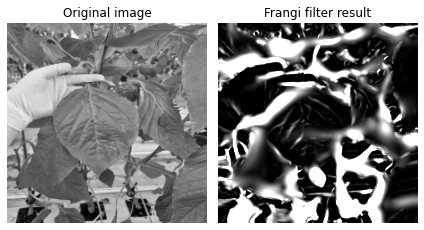

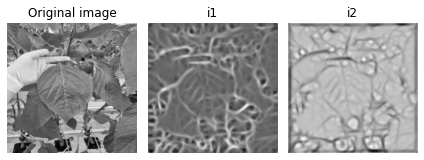

In [31]:
from skimage.filters import frangi
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# image = camera()
image = train_x[0].compute()[:,:,1]
plt.close('all')

fig, ax = plt.subplots(ncols=2)

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(
    frangi(image),
    cmap=plt.cm.gray, vmin = 0, vmax = 0.00001)
ax[1].set_title('Frangi filter result')

for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()

#%% Hessian의 Eigen value만 plot

from skimage.feature import hessian_matrix, hessian_matrix_eigvals

hessall = hessian_matrix(image, sigma = 3)
hxx, hxy, hyy = hessall[0],hessall[1],hessall[2]

i1, i2 = hessian_matrix_eigvals([hxx, hxy, hyy])

plt.close('all')
fig, ax = plt.subplots(ncols=3)

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(i1, cmap = plt.cm.gray)
ax[1].set_title('i1')

ax[2].imshow(i2, cmap = plt.cm.gray)
ax[2].set_title('i2')


for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()

In [29]:
frangi(image)

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)